# 중간 단계의 상태(State) 수동 업데이트

LangGraph는 **중간 단계의 상태를 수동으로 업데이트** 할 수 있는 방안을 제공하고 있습니다.

상태를 업데이트하면 **에이전트의 행동을 수정하여 경로를 제어** 할 수 있으며, 심지어 과거를 수정할 수도 있습니다. 

이 기능은 **에이전트의 실수를 수정** 하거나, **대체 경로를 탐색** 하거나, 특정 목표에 따라 **에이전트의 동작을 변경** 할 때 특히 유용합니다.

- 참고: 본 튜토리얼에서 사용하는 에이전트는 이전 튜토리얼과 동일한 그래프를 정의합니다.

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [2]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH17-LangGraph-Modules")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LangGraph-Modules


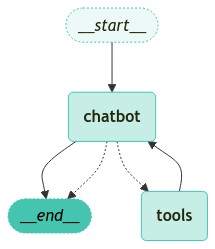

In [3]:
from typing import Annotated
from typing_extensions import TypedDict

from langchain_teddynote.tools.tavily import TavilySearch
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_teddynote.graphs import visualize_graph


########## 1. 상태 정의 ##########
# 상태 정의
class State(TypedDict):
    # 메시지 목록 주석 추가
    messages: Annotated[list, add_messages]


########## 2. 도구 정의 및 바인딩 ##########
# 도구 초기화
tool = TavilySearch(max_results=3)

# 도구 목록 정의
tools = [tool]

# LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini")

# 도구와 LLM 결합
llm_with_tools = llm.bind_tools(tools)


########## 3. 노드 추가 ##########
# 챗봇 함수 정의
def chatbot(state: State):
    # 메시지 호출 및 반환
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# 상태 그래프 생성
graph_builder = StateGraph(State)

# 챗봇 노드 추가
graph_builder.add_node("chatbot", chatbot)


# 도구 노드 생성 및 추가
tool_node = ToolNode(tools=tools)

# 도구 노드 추가
graph_builder.add_node("tools", tool_node)

# 조건부 엣지
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

########## 4. 엣지 추가 ##########

# tools > chatbot
graph_builder.add_edge("tools", "chatbot")

# START > chatbot
graph_builder.add_edge(START, "chatbot")

# chatbot > END
graph_builder.add_edge("chatbot", END)

########## 5. 그래프 컴파일 ##########
# 메모리 저장소 초기화
memory = MemorySaver()

# 그래프 빌더 컴파일
graph = graph_builder.compile(checkpointer=memory)

########## 6. 그래프 시각화 ##########
# 그래프 시각화
visualize_graph(graph)

In [4]:
from langchain_core.runnables import RunnableConfig

# 질문
question = "LangGraph 가 무엇인지 조사하여 알려주세요!"

# 초기 입력 상태를 정의
input = State(messages=[("user", question)])

# config 설정
config = RunnableConfig(
    configurable={"thread_id": "1"},  # 스레드 ID 설정
)

우선 채널목록을 출력하여 **interrupt_before** 와 **interrupt_after** 를 적용할 수 있는 목록을 출력합니다.

In [5]:
# 그래프 채널 목록 출력
list(graph.channels)

['messages',
 '__start__',
 'chatbot',
 'tools',
 'start:chatbot',
 'branch:chatbot:tools_condition:chatbot',
 'branch:chatbot:tools_condition:tools']

In [6]:
# 그래프 스트림 호출
events = graph.stream(
    input=input, config=config, interrupt_before=["tools"], stream_mode="values"
)

# 이벤트 반복 처리
for event in events:
    # 메시지가 이벤트에 포함된 경우
    if "messages" in event:
        # 마지막 메시지의 예쁜 출력
        event["messages"][-1].pretty_print()

================================ Human Message =================================

LangGraph 가 무엇인지 조사하여 알려주세요!
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_uAZwKKbpIcMsKKOHI6aFIMty)
 Call ID: call_uAZwKKbpIcMsKKOHI6aFIMty
  Args:
    query: LangGraph


현재 단계는 `ToolNode` 에 의해 중단되었습니다.

가장 최근 메시지를 확인하면 `ToolNode` 가 검색을 수행하기 전 `query` 를 포함하고 있음을 알 수 있습니다.

여기서는 `query` 가 단순하게 `LangGraph` 라는 단어만을 포함하고 있습니다. (기존의 질문은 `"LangGraph 가 무엇인지 조사하여 알려주세요!"` 였습니다.)

당연하게도, 웹 검색 결과가 우리가 원하는 결과와 다를 수 있습니다.

In [7]:
# 그래프 상태 스냅샷 생성
snapshot = graph.get_state(config)

# 가장 최근 메시지 추출
last_message = snapshot.values["messages"][-1]

# 메시지 출력
last_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_uAZwKKbpIcMsKKOHI6aFIMty)
 Call ID: call_uAZwKKbpIcMsKKOHI6aFIMty
  Args:
    query: LangGraph


## 사람의 개입 (Human-in-the-loop)

- `TavilySearch` 도구에서 **검색 결과** 를 수정

우리는 종종 `ToolMessage` 의 결과가 마음에 들지 않는 경우가 있습니다.

특히, 웹 검색하여 얻은 답변은 얼마든지 잘못된 정보가 포함될 수 있고, 이는 곧 챗봇의 답변에도 영향을 미칠 수 있습니다.

만약, 사람이 중간에 개입하여 웹 검색 도구인 `Tavily Tool` 의 검색 결과인 `ToolMessage` 를 수정하여 LLM 에게 전달하고 싶다면 어떻게 해야 할까요?

![](./image/langgraph-01.png)

아래는 원래의 웹 검색 결과와는 조금 다른 수정한 가상의 웹 검색 결과를 만들어 보았습니다

In [8]:
modified_search_result = """[수정된 웹 검색 결과] 
LangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM을 활용해 구축할 수 있도록 지원합니다.
LangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공하는 오픈 소스 라이브러리입니다.

자세한 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/) 과
테디노트의 [랭체인 한국어 튜토리얼](https://wikidocs.net/233785) 을 참고하세요."""

print(modified_search_result)

[수정된 웹 검색 결과] 
LangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM을 활용해 구축할 수 있도록 지원합니다.
LangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공하는 오픈 소스 라이브러리입니다.

자세한 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/) 과
테디노트의 [랭체인 한국어 튜토리얼](https://wikidocs.net/233785) 을 참고하세요.


다음으로는 수정한 검색 결과를 `ToolMessage` 에 주입합니다.

**중요**

- 여기서 메시지를 수정하려면 수정하고자 하는 Message 와 일치하는 `tool_call_id` 를 지정해야 합니다.

In [9]:
# 수정하고자 하는 `ToolMessage` 의 `tool_call_id` 추출
tool_call_id = last_message.tool_calls[0]["id"]
print(tool_call_id)

call_uAZwKKbpIcMsKKOHI6aFIMty


In [10]:
from langchain_core.messages import AIMessage, ToolMessage

new_messages = [
    # LLM API의 도구 호출과 일치하는 ToolMessage 필요
    ToolMessage(
        content=modified_search_result,
        tool_call_id=tool_call_id,
    ),
    # LLM의 응답에 직접적으로 내용 추가
    # AIMessage(content=modified_search_result),
]

new_messages[-1].pretty_print()

================================= Tool Message =================================

[수정된 웹 검색 결과] 
LangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM을 활용해 구축할 수 있도록 지원합니다.
LangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공하는 오픈 소스 라이브러리입니다.

자세한 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/) 과
테디노트의 [랭체인 한국어 튜토리얼](https://wikidocs.net/233785) 을 참고하세요.


### StateGraph의 `update_state` 메서드

`update_state` 메서드는 주어진 값으로 그래프의 상태를 업데이트합니다. 이 메서드는 마치 `as_node`에서 값이 온 것처럼 동작합니다.

**매개변수**

- `config` (RunnableConfig): 실행 구성
- `values` (Optional[Union[dict[str, Any], Any]]): 업데이트할 값들
- `as_node` (Optional[str]): 값의 출처로 간주할 노드 이름. 기본값은 None

**반환값**

- RunnableConfig

**주요 기능**

1. 체크포인터를 통해 이전 상태를 로드하고 새로운 상태를 저장합니다.
2. 서브그래프에 대한 상태 업데이트를 처리합니다.
3. `as_node`가 지정되지 않은 경우, 마지막으로 상태를 업데이트한 노드를 찾습니다.
4. 지정된 노드의 writer들을 실행하여 상태를 업데이트합니다.
5. 업데이트된 상태를 체크포인트에 저장합니다.

**주요 로직**

1. 체크포인터를 확인하고, 없으면 ValueError를 발생시킵니다.
2. 서브그래프에 대한 업데이트인 경우, 해당 서브그래프의 `update_state` 메서드를 호출합니다.
3. 이전 체크포인트를 로드하고, 필요한 경우 `as_node`를 결정합니다.
4. 지정된 노드의 writer들을 사용하여 상태를 업데이트합니다.
5. 업데이트된 상태를 새로운 체크포인트로 저장합니다.

**참고**

- 이 메서드는 그래프의 상태를 수동으로 업데이트할 때 사용됩니다.
- 체크포인터를 사용하여 상태의 버전 관리와 지속성을 보장합니다.
- `as_node`를 지정하지 않으면 자동으로 결정되지만, 모호한 경우 오류가 발생할 수 있습니다.
- 상태 업데이트 중 SharedValues에 쓰기 작업은 허용되지 않습니다.

In [11]:
graph.update_state(
    # 업데이트할 상태 지정
    config,
    # 제공할 업데이트된 값. `State`의 메시지는 "추가 전용"으로 기존 상태에 추가됨
    {"messages": new_messages},
    as_node="tools",
)

print("(최근 1개의 메시지 출력)\n")
print(graph.get_state(config).values["messages"][-1])

(최근 1개의 메시지 출력)

content='[수정된 웹 검색 결과] \nLangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM을 활용해 구축할 수 있도록 지원합니다.\nLangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공하는 오픈 소스 라이브러리입니다.\n\n자세한 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/) 과\n테디노트의 [랭체인 한국어 튜토리얼](https://wikidocs.net/233785) 을 참고하세요.' id='7eb0cf12-f253-44a8-b0f4-c2cbb718c172' tool_call_id='call_uAZwKKbpIcMsKKOHI6aFIMty'


이제 그래프가 완성되었습니다. 

최종 응답 메시지를 제공했기 때문입니다! 

상태 업데이트는 그래프 단계를 시뮬레이션하므로, 해당하는 `traces`도 생성합니다.

`messages`를 사전 정의된 `add_messages` 함수로 `Annotated` 처리했습니다. (이는 그래프에 기존 목록을 직접 덮어쓰지 않고 항상 값을 추가합니다.)

동일한 논리가 여기에도 적용되어, `update_state`에 전달된 메시지가 동일한 방식으로 메시지가 추가하게 됩니다.

`update_state` 함수는 마치 그래프의 노드 중 하나인 것처럼 작동합니다! 기본적으로 업데이트 작업은 마지막으로 실행된 노드를 사용하지만, 아래에서 수동으로 지정할 수 있습니다. 업데이트를 추가하고 그래프에 "chatbot"에서 온 것처럼 처리하도록 지시해 봅시다.


In [13]:
snapshot = graph.get_state(config)
snapshot.next

('chatbot',)

In [14]:
# `None`는 현재 상태에 아무것도 추가하지 않음
events = graph.stream(None, config, stream_mode="values")

# 이벤트 반복 처리
for event in events:
    # 메시지가 이벤트에 포함된 경우
    if "messages" in event:
        # 마지막 메시지의 예쁜 출력
        event["messages"][-1].pretty_print()

================================= Tool Message =================================

[수정된 웹 검색 결과] 
LangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM을 활용해 구축할 수 있도록 지원합니다.
LangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공하는 오픈 소스 라이브러리입니다.

자세한 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/) 과
테디노트의 [랭체인 한국어 튜토리얼](https://wikidocs.net/233785) 을 참고하세요.
================================== Ai Message ==================================

LangGraph는 상태 기반의 다중 액터 애플리케이션을 대형 언어 모델(LLM)을 활용하여 구축할 수 있도록 지원하는 오픈 소스 라이브러리입니다. 이 라이브러리는 사이클 흐름, 제어 가능성, 지속성 및 클라우드 배포 기능을 제공하여 개발자들이 복잡한 애플리케이션을 보다 쉽게 개발할 수 있게 돕습니다.

자세한 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/)과 테디노트의 [랭체인 한국어 튜토리얼](https://wikidocs.net/233785)에서 확인할 수 있습니다.


아래는 최종 답변의 상태도 수정하고자 할 경우 사용할 수 있는 코드입니다.

In [ ]:
# 이 함수가 작동할 노드 지정. 이 노드가 방금 실행된 것처럼 자동으로 처리 계속
# graph.update_state(
#     config,
#     {
#         "messages": [
#             AIMessage(content="마지막으로 최종 메시지를 추가하여 마무리 합니다.")
#         ]
#     },
#     as_node="chatbot",
# )

그럼, 그래프를 시각화하고 전체 출력을 확인해 보겠습니다.

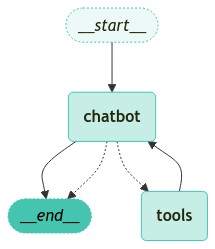

In [15]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

현재 상태를 이전과 같이 점검하여 체크포인트가 수동 업데이트를 반영하는지 확인합니다.

In [16]:
# 그래프 상태 스냅샷 생성
snapshot = graph.get_state(config)

# 최근 세 개의 메시지 출력
for message in snapshot.values["messages"]:
    message.pretty_print()

================================ Human Message =================================

LangGraph 가 무엇인지 조사하여 알려주세요!
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_uAZwKKbpIcMsKKOHI6aFIMty)
 Call ID: call_uAZwKKbpIcMsKKOHI6aFIMty
  Args:
    query: LangGraph
================================= Tool Message =================================

[수정된 웹 검색 결과] 
LangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM을 활용해 구축할 수 있도록 지원합니다.
LangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공하는 오픈 소스 라이브러리입니다.

자세한 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/) 과
테디노트의 [랭체인 한국어 튜토리얼](https://wikidocs.net/233785) 을 참고하세요.
================================== Ai Message ==================================

LangGraph는 상태 기반의 다중 액터 애플리케이션을 대형 언어 모델(LLM)을 활용하여 구축할 수 있도록 지원하는 오픈 소스 라이브러리입니다. 이 라이브러리는 사이클 흐름, 제어 가능성, 지속성 및 클라우드 배포 기능을 제공하여 개발자들이 복잡한 애플리케이션을 보다 쉽게 개발할 수 있게 돕습니다.

자세한 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/la

진행할 다음 노드가 있는지 확인합니다. `()` 가 비어 있는 것으로 확인할 수 있습니다. 즉, 모든 과정이 정상적으로 진행되었음을 알 수 있습니다.

In [18]:
# 다음 상태 출력
print(snapshot.next)

()


## Interrupt 후 메시지 상태 업데이트 - 이어서 진행

- `TavilySearch` 도구에서 **검색 쿼리** 를 수정

이번에는 다음 노드로 진행하기 전 interrupt 를 발생시켜 중단하고, 상태(State) 를 갱신한 뒤 이어서 진행하는 방법을 살펴보겠습니다.

먼저, 새로운 `thread_id` 를 생성합니다.

여기서는 랜덤한 해시값을 생성하는 `generate_random_hash` 함수를 사용합니다.

In [19]:
from langchain_teddynote.graphs import generate_random_hash

thread_id = generate_random_hash()
print(f"thread_id: {thread_id}")

question = "LangGraph 에 대해서 배워보고 싶습니다. 유용한 자료를 추천해 주세요!"

# 초기 입력 상태를 정의
input = State(messages=[("user", question)])

# 새로운 config 생성
config = {"configurable": {"thread_id": thread_id}}

events = graph.stream(
    input=input,
    config=config,
    interrupt_before=["tools"],
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

thread_id: 6c95af
================================ Human Message =================================

LangGraph 에 대해서 배워보고 싶습니다. 유용한 자료를 추천해 주세요!
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_xJVDxiPGNJcHmErUMrCEMxdF)
 Call ID: call_xJVDxiPGNJcHmErUMrCEMxdF
  Args:
    query: LangGraph 소개 및 자료


다음으로, 에이전트를 위한 도구 호출을 업데이트해 보겠습니다. 

먼저 `Message ID` 를 가져옵니다.

In [20]:
# config 를 복사
config_copy = config.copy()

In [21]:
from langchain_core.messages import AIMessage

# 스냅샷 상태 가져오기
snapshot = graph.get_state(config)

# messages 의 마지막 메시지 가져오기
existing_message = snapshot.values["messages"][-1]

# 메시지 ID 출력
print("Message ID", existing_message.id)

Message ID run-f78c69ba-6403-45dc-b355-28a2b326471e-0


마지막 메시지는 `tavily_web_search` 도구 호출과 관련된 메시지 입니다.

주요 속성은 다음과 같습니다.

- `name`: 도구의 이름
- `args`: 검색 쿼리
- `id`: 도구 호출 ID
- `type`: 도구 호출 유형(tool_call)

In [22]:
# 첫 번째 도구 호출 출력
print(existing_message.tool_calls[0])

{'name': 'tavily_web_search', 'args': {'query': 'LangGraph 소개 및 자료'}, 'id': 'call_xJVDxiPGNJcHmErUMrCEMxdF', 'type': 'tool_call'}


위의 속성 값 중 `args` 의 `query` 를 업데이트 해 보겠습니다.

기존의 `existing_message` 를 복사하여 새로운 도구인 `new_tool_call` 을 생성합니다.

`copy()` 메서드를 사용하여 복사하였기 때문에 모든 속성 값이 복사됩니다.

그런 다음, `query` 매개변수에 원하는 **검색 쿼리** 를 입력합니다.

**중요**

- `id` 는 기존 메시지의 `id` 를 그대로 사용합니다. (`id` 가 달라지면 message 리듀서가 동작하여 메시지를 갱신하지 않고, 추가하게 됩니다.)

In [23]:
# tool_calls 를 복사하여 새로운 도구 호출 생성
new_tool_call = existing_message.tool_calls[0].copy()

# 쿼리 매개변수 업데이트(갱신)
new_tool_call["args"] = {"query": "LangGraph site:teddylee777.github.io"}
new_tool_call

{'name': 'tavily_web_search',
 'args': {'query': 'LangGraph site:teddylee777.github.io'},
 'id': 'call_xJVDxiPGNJcHmErUMrCEMxdF',
 'type': 'tool_call'}

In [25]:
# AIMessage 생성
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[new_tool_call],
    # 중요! ID는 메시지를 상태에 추가하는 대신 교체하는 방법
    id=existing_message.id,
)

print(new_message.id)

# 수정한 메시지 출력
new_message.pretty_print()

run-f78c69ba-6403-45dc-b355-28a2b326471e-0
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_xJVDxiPGNJcHmErUMrCEMxdF)
 Call ID: call_xJVDxiPGNJcHmErUMrCEMxdF
  Args:
    query: LangGraph site:teddylee777.github.io


검색 쿼리가 갱신된 것을 확인할 수 있습니다.

In [26]:
# 업데이트된 도구 호출 출력
print(new_message.tool_calls[0])

# 메시지 ID 출력
print("\nMessage ID", new_message.id)

# 상태 업데이트
graph.update_state(config, {"messages": [new_message]})

{'name': 'tavily_web_search', 'args': {'query': 'LangGraph site:teddylee777.github.io'}, 'id': 'call_xJVDxiPGNJcHmErUMrCEMxdF', 'type': 'tool_call'}

Message ID run-f78c69ba-6403-45dc-b355-28a2b326471e-0


{'configurable': {'thread_id': '6c95af',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef99e9c-a81a-63e6-8002-84fbc4bcb50a'}}

업데이트된 마지막 message 의 `tool_calls` 를 확인합니다.

- `args` 의 `query` 가 수정된 것을 확인할 수 있습니다.

In [27]:
# 마지막 메시지의 도구 호출 가져오기
graph.get_state(config).values["messages"][-1].tool_calls

[{'name': 'tavily_web_search',
  'args': {'query': 'LangGraph site:teddylee777.github.io'},
  'id': 'call_xJVDxiPGNJcHmErUMrCEMxdF',
  'type': 'tool_call'}]

기존 검색어인 **"LangGraph"** 대신 변경된 검색 쿼리인 **"LangGraph site:teddylee777.github.io"** 로 검색되는 것을 확인할 수 있습니다.

기존 설정과 `None` 입력을 사용하여 그래프 이어서 스트리밍 합니다.

In [28]:
# 그래프 스트림에서 이벤트 수신
events = graph.stream(None, config, stream_mode="values")

# 각 이벤트에 대한 처리
for event in events:
    # 메시지가 있는 경우 마지막 메시지 출력
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_xJVDxiPGNJcHmErUMrCEMxdF)
 Call ID: call_xJVDxiPGNJcHmErUMrCEMxdF
  Args:
    query: LangGraph site:teddylee777.github.io
================================= Tool Message =================================
Name: tavily_web_search

["<document><title>LangGraph - Multi-Agent Collaboration(다중 협업 ... - 테디노트</title><url>https://teddylee777.github.io/langgraph/langgraph-multi-agent-collaboration/</url><content>LangGraph 라이브러리가 출시하게 된 가장 큰 이유는 \\\"복잡한 문제들은 단일 AI 에이전트만으로 해결하기 어렵다\\\" 라는 문장에서 시작합니다. 이 글에서는 LangGraph의 다중 에이전트 협업을 통해 이러한 문제들을 효과적으로 해결하는 방법을 소개합니다.</content><raw>🔥알림🔥\n① 테디노트 유튜브 -\n구경하러 가기!\n② LangChain 한국어 튜토리얼\n바로가기 👀\n③ 랭체인 노트 무료 전자책(wikidocs)\n바로가기 🙌\n④ RAG 비법노트 LangChain 강의오픈\n바로가기 🙌\n⑤ 서울대 PyTorch 딥러닝 강의\n바로가기 🙌\nLangGraph - Multi-Agent Collaboration(다중 협업 에이전트) 로 복잡한 테스크를 수행하는 LLM 어플리케이션 제작\n2024년 01월 29일\n26 분 소요\nLangChain 에서 야심차게 LangGraph 를 새롭게 출시하였습니다. La

In [29]:
# 이벤트 스트림 생성
events = graph.stream(
    {
        "messages": (
            "user",
            "내가 지금까지 배운 내용에 대해서 매우 친절하고 정성스럽게 한국어로 답변해줘! 출처를 반드시 포함해줘!",
        )
    },
    config,
    stream_mode="values",
)

# 메시지 이벤트 처리
for event in events:
    if "messages" in event:
        # 마지막 메시지 출력
        event["messages"][-1].pretty_print()

================================ Human Message =================================

내가 지금까지 배운 내용에 대해서 매우 친절하고 정성스럽게 한국어로 답변해줘! 출처를 반드시 포함해줘!
================================== Ai Message ==================================

물론입니다! 지금까지 배운 내용을 친절하고 정성스럽게 요약해드리겠습니다.

---

### LangGraph 개요

LangGraph는 복잡한 문제를 해결하기 위해 다중 에이전트 협업을 가능하게 하는 라이브러리입니다. 이 라이브러리는 단일 AI 에이전트로는 해결하기 어려운 문제들을 나누고 정복하는 방식으로 접근합니다. 즉, 각 작업이나 도메인에 특화된 에이전트를 만들고, 이 에이전트들이 팀워크를 통해 문제를 해결하도록 합니다.

### 주요 기능

1. **다중 에이전트 협업**:
   - LangGraph는 여러 개의 AI 에이전트가 서로 협력하여 작업을 수행하도록 설계되었습니다. 각 에이전트는 특정 도메인이나 작업에 최적화되어 있어, 복잡한 문제를 효과적으로 해결할 수 있습니다.

2. **전문화된 에이전트 생성**:
   - 복잡한 작업에 대해 전문화된 에이전트를 만들어 작업을 올바른 전문가에게 라우팅합니다. 이를 통해 각 에이전트가 최적의 성능을 발휘할 수 있습니다.

3. **상태 기반 워크플로우**:
   - LangGraph는 상태 그래프를 사용하여 에이전트 간의 상호작용을 관리합니다. 각 에이전트의 상태를 정의하고, 메시지의 흐름을 추적하여 작업을 진행합니다.

4. **도구와 기능 통합**:
   - LangGraph는 다양한 도구와 기능을 통합하여 사용할 수 있습니다. 예를 들어, Python REPL 도구를 통해 코드를 실행하거나, 특정 작업을 수행할 수 있는 기능을 포함합니다.

### 활용 사례

- **문서 검색 및 처리**: LangGraph 

최종 상태에서 `messages` 의 마지막 메시지를 확인합니다. (이는 곧 최종 응답 메시지입니다.)

In [30]:
graph.get_state(config).values["messages"][-1].pretty_print()

================================== Ai Message ==================================

물론입니다! 지금까지 배운 내용을 친절하고 정성스럽게 요약해드리겠습니다.

---

### LangGraph 개요

LangGraph는 복잡한 문제를 해결하기 위해 다중 에이전트 협업을 가능하게 하는 라이브러리입니다. 이 라이브러리는 단일 AI 에이전트로는 해결하기 어려운 문제들을 나누고 정복하는 방식으로 접근합니다. 즉, 각 작업이나 도메인에 특화된 에이전트를 만들고, 이 에이전트들이 팀워크를 통해 문제를 해결하도록 합니다.

### 주요 기능

1. **다중 에이전트 협업**:
   - LangGraph는 여러 개의 AI 에이전트가 서로 협력하여 작업을 수행하도록 설계되었습니다. 각 에이전트는 특정 도메인이나 작업에 최적화되어 있어, 복잡한 문제를 효과적으로 해결할 수 있습니다.

2. **전문화된 에이전트 생성**:
   - 복잡한 작업에 대해 전문화된 에이전트를 만들어 작업을 올바른 전문가에게 라우팅합니다. 이를 통해 각 에이전트가 최적의 성능을 발휘할 수 있습니다.

3. **상태 기반 워크플로우**:
   - LangGraph는 상태 그래프를 사용하여 에이전트 간의 상호작용을 관리합니다. 각 에이전트의 상태를 정의하고, 메시지의 흐름을 추적하여 작업을 진행합니다.

4. **도구와 기능 통합**:
   - LangGraph는 다양한 도구와 기능을 통합하여 사용할 수 있습니다. 예를 들어, Python REPL 도구를 통해 코드를 실행하거나, 특정 작업을 수행할 수 있는 기능을 포함합니다.

### 활용 사례

- **문서 검색 및 처리**: LangGraph Retrieval Agent를 사용하여 언어 처리 및 데이터베이스 관리 등을 통해 동적인 문서 검색과 처리를 수행할 수 있습니다.
- **정형 데이터 분석**: CSV 또는 Excel 파일에 대한 질의응답을 통해 데이터 분석을 수행할 수 있으며, 자연

## 지난 스냅샷의 결과 수정 및 Replay

이번에는 지난 스냅샷의 결과를 수정하여 Replay 하는 방법을 살펴보겠습니다.

지난 스냅샷을 확인 후 특정 노드로 되돌아가, **상태(State) 를 수정한 뒤 해당 노드부터 다시 진행**합니다.

이를 Replay 라고 합니다.

먼저 지난 스냅샷의 상태를 가져옵니다.

In [31]:
to_replay_state = None

# 상태 기록 가져오기
for state in graph.get_state_history(config):

    messages = state.values["messages"]

    if len(messages) > 0:
        print(state.values["messages"][-1].id)
        # 메시지 수 및 다음 상태 출력
        print("메시지 수: ", len(state.values["messages"]), "다음 노드: ", state.next)
        print("-" * 80)
        # 특정 상태 선택 기준: 채팅 메시지 수
        if len(state.values["messages"]) == 2:
            # 특정 메시지 ID 선택
            to_replay_state = state

run-55afc5ee-6d63-4b11-b2a7-2835553e09d6-0
메시지 수:  6 다음 노드:  ()
--------------------------------------------------------------------------------
d45abb6b-b2c4-40f8-86ce-1038fc289d0f
메시지 수:  5 다음 노드:  ('chatbot',)
--------------------------------------------------------------------------------
run-af0f4be0-8950-4c29-b996-93e9332ca1d9-0
메시지 수:  4 다음 노드:  ('__start__',)
--------------------------------------------------------------------------------
run-af0f4be0-8950-4c29-b996-93e9332ca1d9-0
메시지 수:  4 다음 노드:  ()
--------------------------------------------------------------------------------
b599532c-fea7-4dac-918a-787264946d9b
메시지 수:  3 다음 노드:  ('chatbot',)
--------------------------------------------------------------------------------
run-f78c69ba-6403-45dc-b355-28a2b326471e-0
메시지 수:  2 다음 노드:  ('tools',)
--------------------------------------------------------------------------------
run-f78c69ba-6403-45dc-b355-28a2b326471e-0
메시지 수:  2 다음 노드:  ('tools',)
------------------------------

선택한 메시지의 내용을 확인합니다.

In [32]:
from langchain_teddynote.messages import display_message_tree

# 선택한 메시지 가져오기
existing_message = to_replay_state.values["messages"][-1]

# 메시지 트리 출력
display_message_tree(existing_message)

    content: ""
    additional_kwargs:
        tool_calls:
            index [0]
                id: "call_xJVDxiPGNJcHmErUMrCEMxdF"
                function: {"arguments": "{"query":"LangGraph 소개 및 자료"}", "name": "tavily_web_search"}
                type: "function"
        refusal: None
    response_metadata:
        token_usage:
            completion_tokens: 21
            prompt_tokens: 97
            total_tokens: 118
            completion_tokens_details: {"audio_tokens": None, "reasoning_tokens": 0}
            prompt_tokens_details: {"audio_tokens": None, "cached_tokens": 0}
        model_name: "gpt-4o-mini-2024-07-18"
        system_fingerprint: "fp_0ba0d124f1"
        finish_reason: "tool_calls"
        logprobs: None
    type: "ai"
    name: None
    id: "run-f78c69ba-6403-45dc-b355-28a2b326471e-0"
    example: False
    tool_calls:
        index [0]
            name: "tavily_web_search"
            args: {"query": "LangGraph 소개 및 자료"}
            id: "call_xJVDxiPGNJcHmErU

검색 쿼리를 업데이트 후 반영이 됐는지 확인합니다.

In [33]:
tool_call = existing_message.tool_calls[0].copy()
tool_call["args"] = {"query": "LangGraph human-in-the-loop workflow site:reddit.com"}
tool_call

{'name': 'tavily_web_search',
 'args': {'query': 'LangGraph human-in-the-loop workflow site:reddit.com'},
 'id': 'call_xJVDxiPGNJcHmErUMrCEMxdF',
 'type': 'tool_call'}

업데이트된 AIMessage 를 생성합니다.

In [34]:
# AIMessage 생성
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[tool_call],
    # 중요! ID는 메시지를 상태에 추가하는 대신 교체하는 방법
    id=existing_message.id,
)

# 수정한 메시지 출력
new_message.tool_calls[0]["args"]

{'query': 'LangGraph human-in-the-loop workflow site:reddit.com'}

아래는 업데이트가 되기 전의 메시지입니다.

In [35]:
# 업데이트 전 메시지 확인
graph.get_state(to_replay_state.config).values["messages"][-1].tool_calls

[{'name': 'tavily_web_search',
  'args': {'query': 'LangGraph 소개 및 자료'},
  'id': 'call_xJVDxiPGNJcHmErUMrCEMxdF',
  'type': 'tool_call'}]

`graph` 에 `update_state` 메서드를 사용하여 상태를 업데이트 합니다.

업데이트된 상태를 `updated_state` 에 저장합니다.

In [36]:
# 상태 업데이트
updated_state = graph.update_state(
    to_replay_state.config,
    {"messages": [new_message]},
)
updated_state

{'configurable': {'thread_id': '6c95af',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef99eb2-a7bb-6966-8002-a7b0cb3acc65'}}

이제 업데이트된 상태를 스트리밍 합니다. 여기서 입력은 `None` 으로 주어 Replay 합니다.

In [37]:
# config 에는 updated_state 를 전달합니다. 이는 임의로 갱신한 상태를 전달하는 것입니다.
for event in graph.stream(None, updated_state, stream_mode="values"):
    # 메시지가 이벤트에 포함된 경우
    if "messages" in event:
        # 마지막 메시지 출력
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_xJVDxiPGNJcHmErUMrCEMxdF)
 Call ID: call_xJVDxiPGNJcHmErUMrCEMxdF
  Args:
    query: LangGraph human-in-the-loop workflow site:reddit.com
================================= Tool Message =================================
Name: tavily_web_search

["<document><title>Insights and Learnings from Building a Complex Multi-Agent System</title><url>https://www.reddit.com/r/LangChain/comments/1byz3lr/insights_and_learnings_from_building_a_complex/</url><content>For the chatbot, Chainlit provides everything we need, except background processing. Let's use that. Langchain and LCEL are both flexible and unify the interfaces with the LLMs. We'll need a rather complicated agent workflow, in fact, multiple ones. LangGraph is more flexible than crew.ai or autogen.</content></document>", "<document><title>Tool-calling agents: Human approval before tool invocation?</title><url>https://www

최종 결과를 출력합니다.

이때 사용하는 `config` 는 최종 상태를 가져오는 것이 아니라, 최종 상태를 가져오기 위한 초기 `config` 입니다.

In [38]:
# 최종 결과 출력
for msg in graph.get_state(config).values["messages"]:
    msg.pretty_print()

================================ Human Message =================================

LangGraph 에 대해서 배워보고 싶습니다. 유용한 자료를 추천해 주세요!
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_xJVDxiPGNJcHmErUMrCEMxdF)
 Call ID: call_xJVDxiPGNJcHmErUMrCEMxdF
  Args:
    query: LangGraph human-in-the-loop workflow site:reddit.com
================================= Tool Message =================================
Name: tavily_web_search

["<document><title>Insights and Learnings from Building a Complex Multi-Agent System</title><url>https://www.reddit.com/r/LangChain/comments/1byz3lr/insights_and_learnings_from_building_a_complex/</url><content>For the chatbot, Chainlit provides everything we need, except background processing. Let's use that. Langchain and LCEL are both flexible and unify the interfaces with the LLMs. We'll need a rather complicated agent workflow, in fact, multiple ones. LangGraph is more flexible than crew.ai or autogen